In [1]:
# Definición y carga de las librerias
from random import sample
import os
import ipyparallel as ipp
rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_row', 1000)                         
pd.set_option('display.max_columns', 50) 
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# from scipy.stats import mode
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_similarity_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Declaración de funciones

# def data_description_ltype(dataset, columnas=['']):
def data_description_ltype(dataset): 
    ds=dataset.dtypes
    ds=pd.DataFrame(ds)
    ds=ds.reset_index()
    ds.columns=['variables','tipos']
#     if columnas != ['']:
#         ds.columns=columnas
    return(ds)

def grafica_ver(data,columna='', titulo='Gráfica',yetiqueta=''):
    if columna == '':
        return(print('ingrese parametros'))
    ax = data[columna].value_counts().plot(kind='bar', figsize=(10,5), color="coral", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title(titulo, fontsize=12)
    ax.set_ylabel(yetiqueta, fontsize=12);
    ax.set_yticks([0, len(data)])
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())
    total = sum(totals)
    for i in ax.patches:
        ax.text(i.get_x()+.12, i.get_height()-3, \
                str(i.get_height())+'\n('+str(round((i.get_height()/len(data))*100, 2))+'%)', fontsize=12,
                    color='dimgrey')

def grafica_hor(data,columna='', titulo='Gráfica',xetiqueta='x'):
    if columna == '':
        return(print('ingrese parametros'))
    
    ax =data[columna].value_counts().plot(kind='barh', figsize=(10,5), color="teal", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title(titulo, fontsize=12)
    ax.set_xlabel(xetiqueta, fontsize=12);
    ax.set_xticks([0, len(data)])
    totals = []                                          # create a list to collect the plt.patches data
    for i in ax.patches:                                 # find the values and append to list
        totals.append(i.get_width())
    total = sum(totals)                                  # set individual bar lables using above list
    for i in ax.patches:                                 
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(i.get_width())+' ('+str(round((i.get_width()/len(data))*100, 2))+'%)', fontsize=12, color='dimgrey')
    return(ax.invert_yaxis())                            # invert for largest on top 

def grafica_nul(data):
    df_limpiar=data.copy()
    df_limpiar= nulos(df_limpiar,'unknown','Nulos')
    df_limpiar= nulos(df_limpiar,999,'Nulos')
    df_limpiar=pd.DataFrame(df_limpiar.isnull().sum(), columns=['nulos'])
    df_limpiar = df_limpiar[df_limpiar.nulos != 0]
    df_limpiar=df_limpiar.sort_values('nulos', ascending=False)
    ax =df_limpiar['nulos'].plot(kind='barh', figsize=(10,5), color="salmon", fontsize=13);
    ax.set_alpha(0.2)
    ax.set_title('Datos Nulos', fontsize=12)
    ax.set_xlabel('Cantidad', fontsize=12);
    ax.set_xticks([0, len(data)])
    totals = []                                          
    for i in ax.patches:                                 
        totals.append(i.get_width())
    total = sum(totals)                                 
    for i in ax.patches:                                 
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(i.get_width())+' ('+str(round((i.get_width()/len(data))*100, 2))+'%)', fontsize=12, color='red')
    return(ax.invert_yaxis())
        
        
# Función para buscar valores y remplazar por otros, se hace para cambiar a nulos valores como los uknonw
def nulos(dataset, valini="",valfin=""):
    new=dataset.copy()
    for n in range(len(dataset.columns)):
#         dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
        if valfin == "Nulos":
            new[dataset.columns[n]]=dataset[dataset.columns[n]].replace([valini],np.NaN)
        else:
            new[dataset.columns[n]]=dataset[dataset.columns[n]].replace([valini],valfin)
    return(new)

def get_labels(dataset,objetive=''):
    target = dataset.loc[:,[objetive]].values
    labels_target=pd.DataFrame(dataset.loc[:,[objetive]].columns, columns=['target'])
    labels=pd.DataFrame(dataset.columns, columns=['full'])
    labels=labels[labels['full']!= objetive]
    labels_num=dataset._get_numeric_data().columns
    labels_text=pd.DataFrame(dataset.drop(labels_num[0],axis=1, inplace=False).columns[:-1], columns=['text'])
    labels_num=pd.DataFrame(labels_num, columns=['num'])
    l= pd.concat([labels,labels_text,labels_num, labels_target], axis=1)
    return(l)

def balanceo(data,objetivo='',tam_muestra=80):
    if objetivo=='':
        return(print('ingrese la variable objetivo para dividir el tamaño de la muestra'))
    df_y_yes=(data[data[objetivo]==1.0].reset_index()).drop('index', axis=1)
    df_y_no=(data[data[objetivo]==0.0].reset_index()).drop('index', axis=1)
    
    N=((data[objetivo][data[objetivo]==1].count()*tam_muestra)/100).astype(int)
    
    rows_y=list(range(0, len(df_y_yes)))
    rows_n=list(range(0, len(df_y_no)))
    
    ran_row_y=sample(rows_y,k=N)
    ran_row_n=sample(rows_n,k=N)
    
    finalDf_train=pd.concat([pd.DataFrame(df_y_yes, index=ran_row_y), pd.DataFrame(df_y_no, index=ran_row_n)])
    finalDf_train=finalDf_train.sort_index()
    
    finalDf_test=pd.concat([df_y_yes.drop(df_y_yes.index[ran_row_y], inplace=False), df_y_no.drop(df_y_no.index[ran_row_y], inplace=False)])
    finalDf_test=finalDf_test.sort_index().reset_index().drop('index', axis=1)
    return(finalDf_train, finalDf_test)

def limpiar_labels(label,columna):
    l=pd.DataFrame(label[columna])
    l=nulos(l,np.NaN,'unknwon')
    l=l[columna][l[columna] != 'unknwon']
    return(l)

# Factorizar
def factor(dataset,full=0):
    enc = LabelEncoder()
    labels=dataset._get_numeric_data().columns
    for n in range(len(dataset.columns)):
        if df.columns[n] not in labels:
            dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
        if full== 1:
            dataset[dataset.columns[n]] = enc.fit_transform(dataset[dataset.columns[n]])
    return(dataset)

#Estilo correlación
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# mapa de correlación
def correl(correlacion):
    cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
    return (correlacion.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Estilo tabla")\
        .set_precision(2)\
        .set_table_styles(magnify()))

def grafica_scores(modelo, x_test, y_test, y_pred): 
    print("Score:",modelo.score(x_test,y_test))
    print("accuracy_score:",accuracy_score(y_true = y_test, y_pred = y_pred))
    print("Tasa de error:",1-accuracy_score(y_true = y_test, y_pred = y_pred))
    print("jaccard_similarity_score",jaccard_similarity_score(y_true=y_test, y_pred=y_pred))
    print(print("\n\nclassification_report\n---------------------\n",classification_report(y_true=y_test, y_pred=y_pred)))

def grafica_matriz_confusion(modelo):
#     modelo = confusion_matrix(y_test, y_pred)
    print('\n')
    ax= plt.subplot()
    sns.heatmap(modelo, annot=True, ax = ax,square=True, cmap="YlGnBu", annot_kws={"size":12}, fmt="d");
    ax.set_xlabel('Predicción' , fontsize='16');
    ax.set_ylabel('Verdaderos' , fontsize='16'); 
    ax.set_title('Matriz de confusión', fontsize='18'); 
    ax.xaxis.set_ticklabels(['no', 'yes'], fontsize='16'); 
    ax.yaxis.set_ticklabels(['no', 'yes'], fontsize='16');

In [3]:
# importación de los datos
df = pd.read_csv('DBM_Data/bank_af.csv', delimiter=";")
df=df.drop(['duration'], axis=1)
# df.dtypes

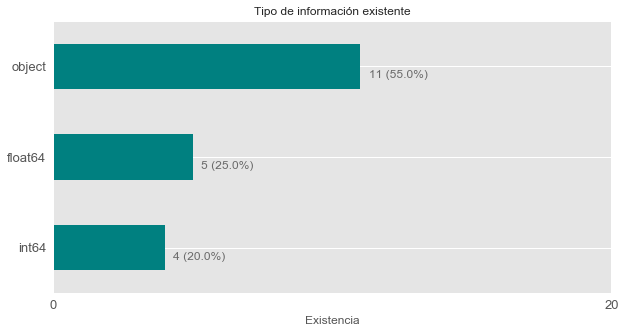

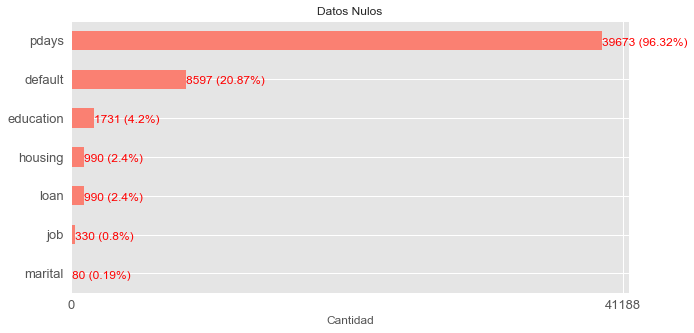

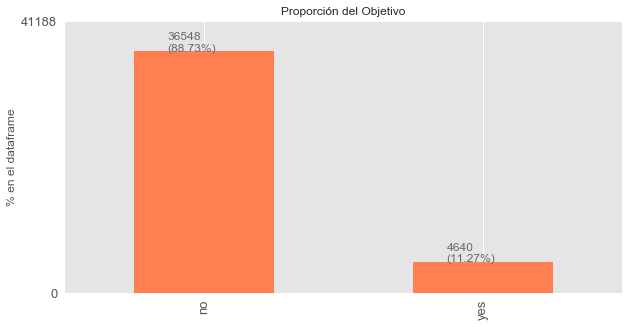

In [4]:
# Revisión de tipos de datos en el dataset
grafica_hor(data_description_ltype(df),'tipos', 'Tipo de información existente','Existencia')
# Revisión de nulos en el dataset
plt.subplots(1, 1)
grafica_nul(df)
# Balanceo de la información en el dataset
plt.subplots(1, 1)
grafica_ver(df,'y','Proporción del Objetivo', '% en el dataframe')

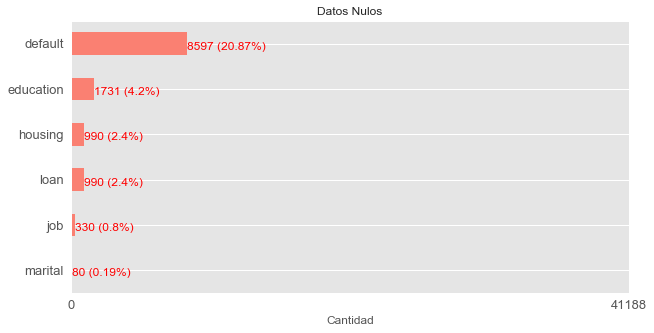

In [5]:
# Eliminación de variable que no aporta valor para el modelo
df=df.drop('pdays',axis=1)
grafica_nul(df)

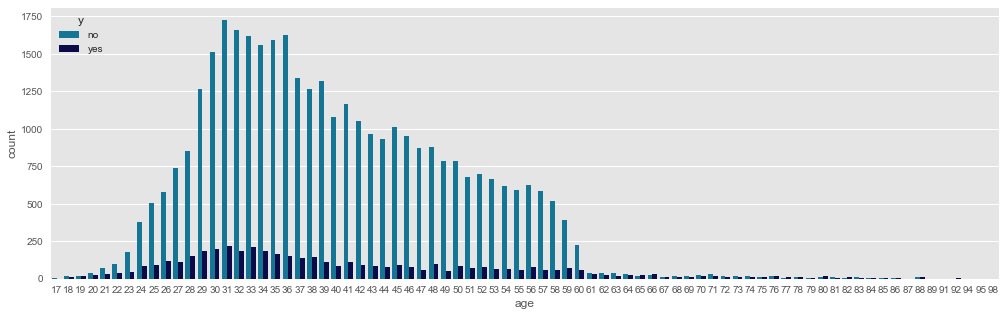

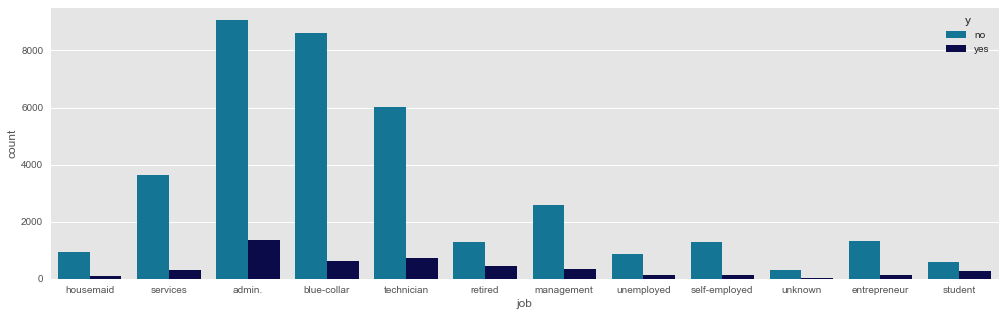

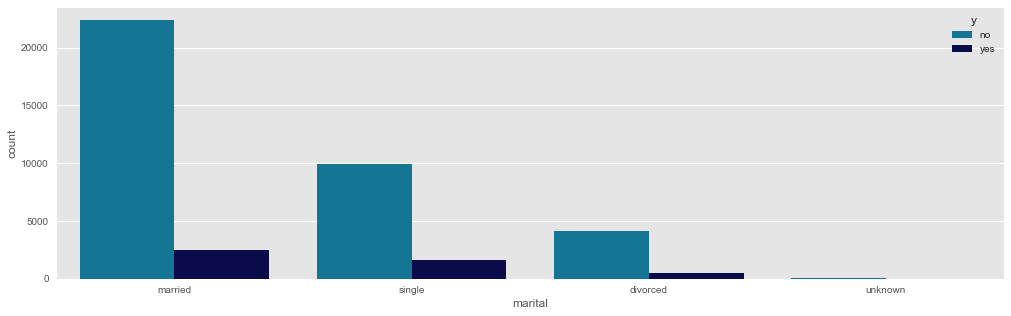

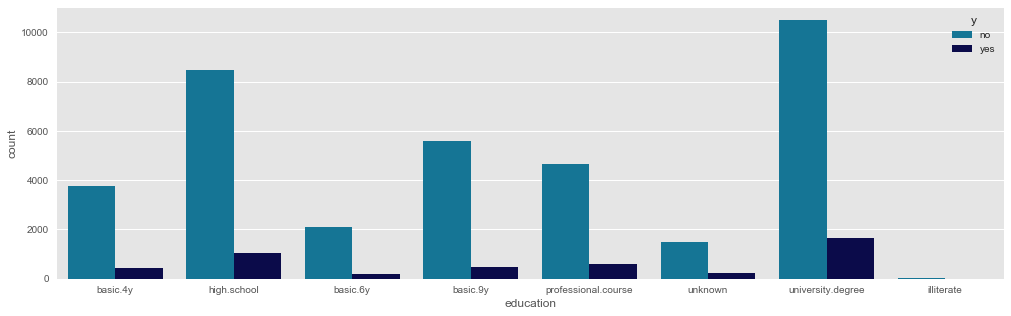

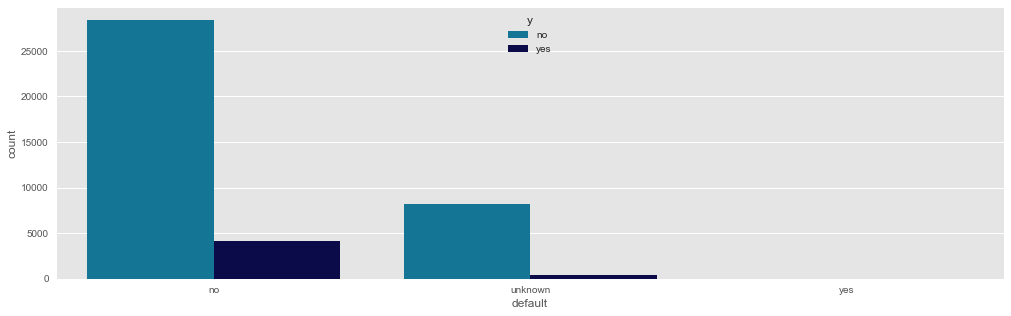

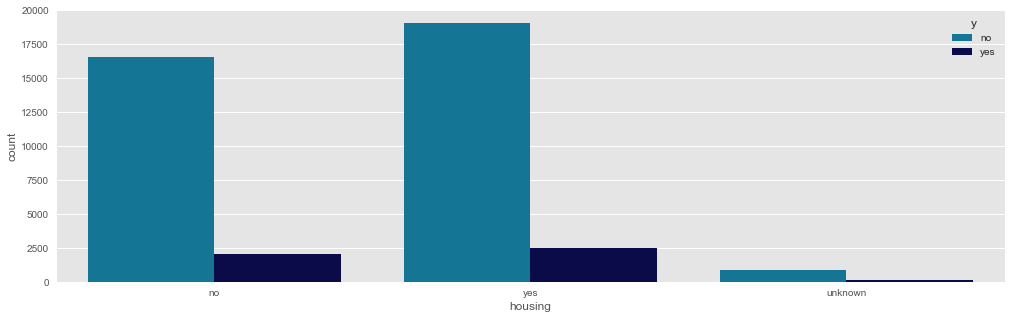

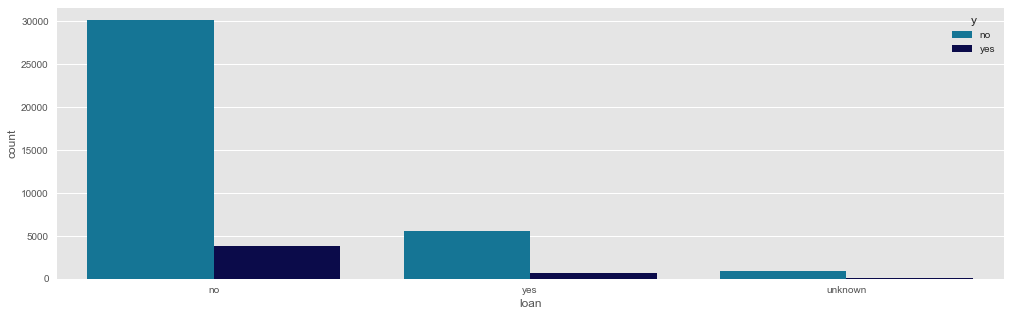

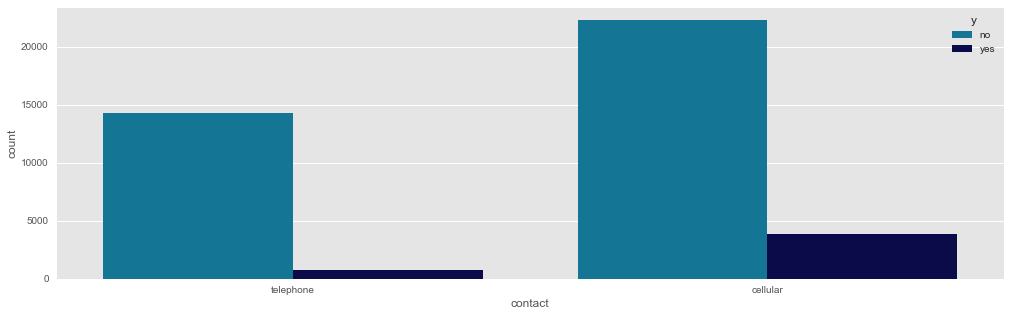

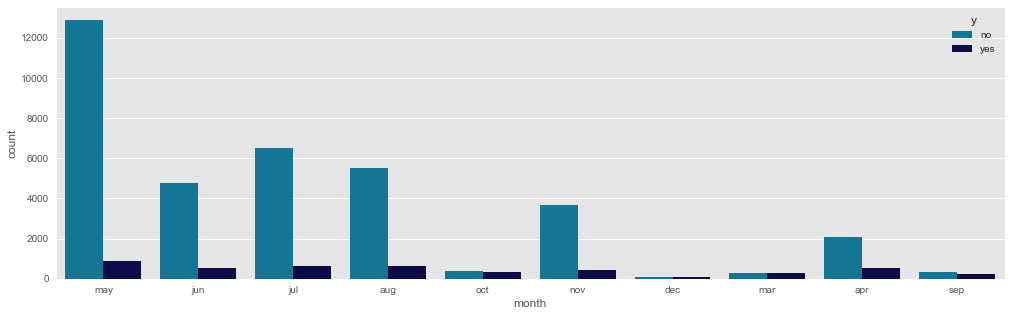

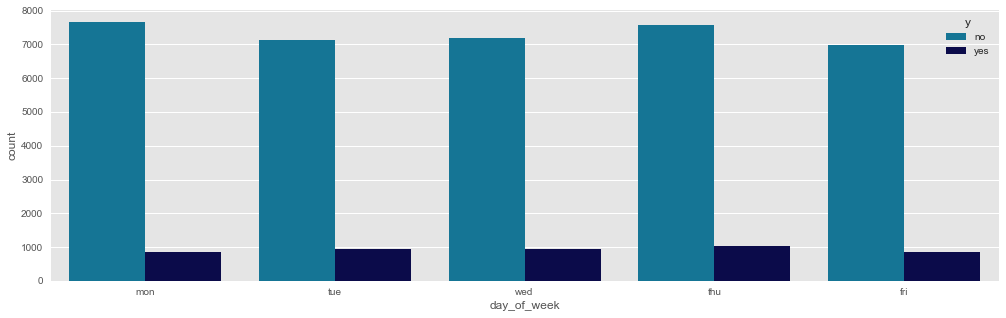

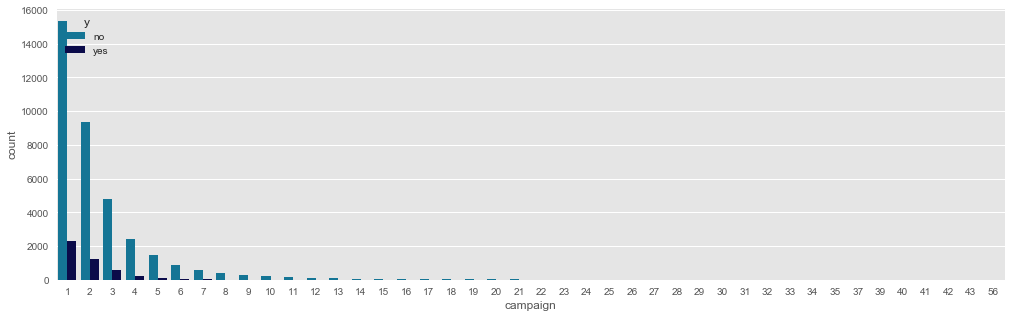

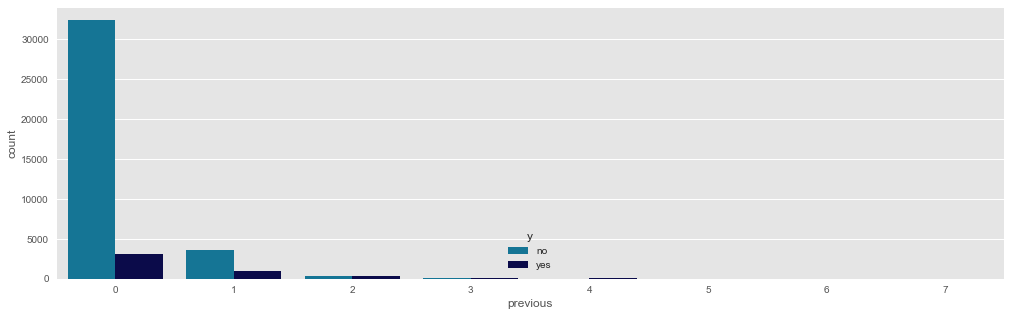

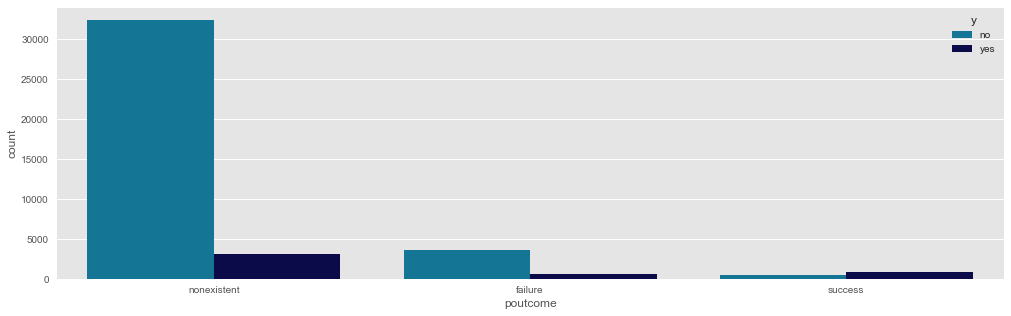

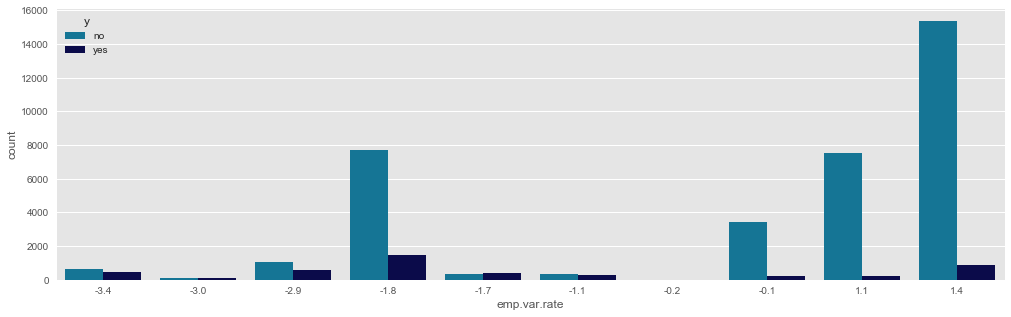

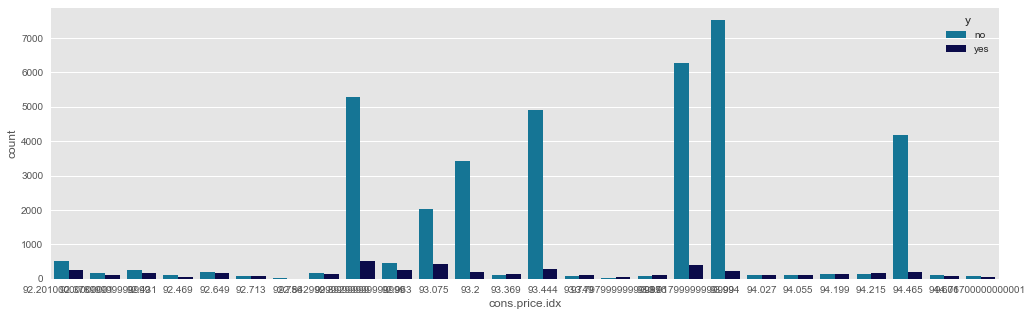

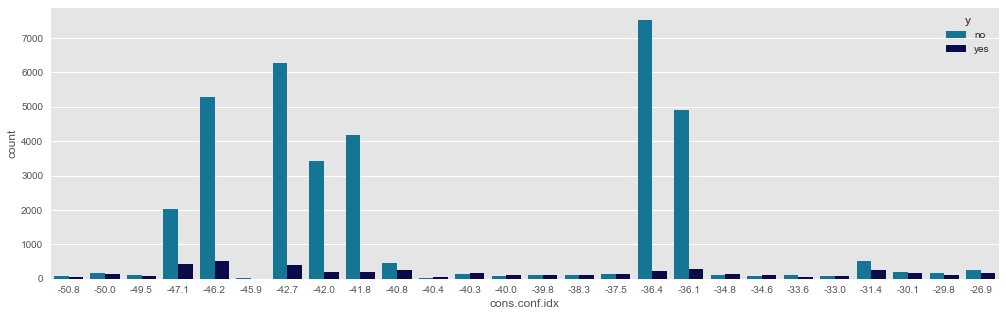

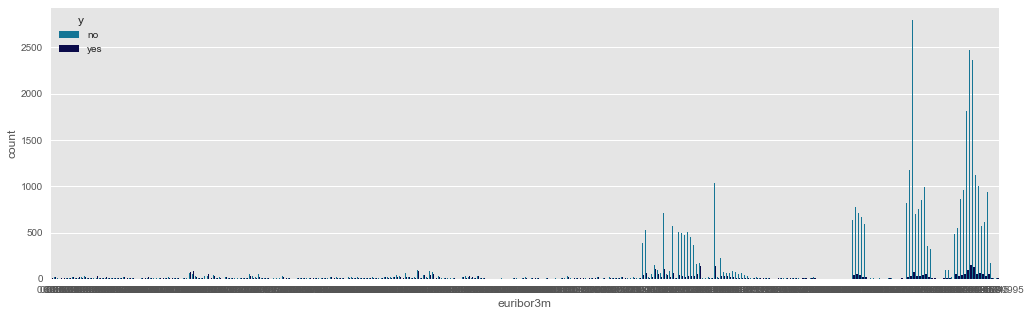

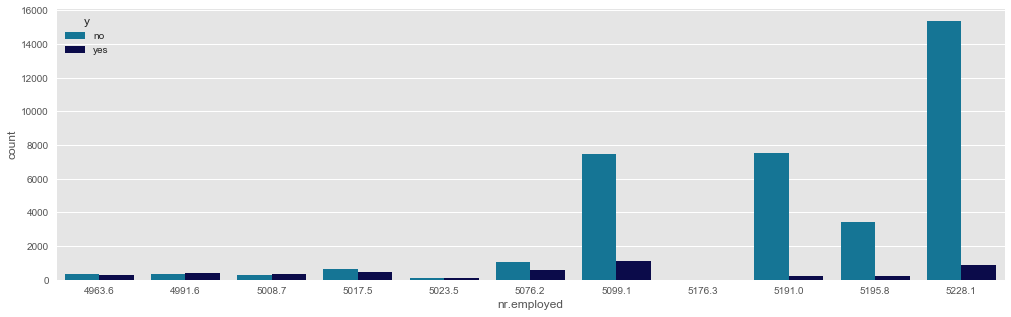

In [6]:
df_labels=df.columns[:-1]
for i in range(len(df_labels)):
    f, ax = plt.subplots(figsize=(17,5))
    sns.countplot(x=df_labels[i], hue="y", data=df, ax=ax, palette="ocean_r")

In [7]:
# education=df.groupby('education').size()
education=pd.DataFrame(df.groupby('education').size()).reset_index()
education.columns=['Nivel Educativo','Conteo']
education

,Nivel Educativo,Conteo
0,basic.4y,4176
1,basic.6y,2292
2,basic.9y,6045
3,high.school,9515
4,illiterate,18
5,professional.course,5243
6,university.degree,12168
7,unknown,1731


In [8]:
# Se organiza y clasifica la variable de nivel educativo, ya que tienen dependencia de precedencia sus valores
df.education=df['education'].replace(['unknown','illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']
                                    ,['0','1','2','3','4','5','6','7'])
df.education=pd.to_numeric(df['education'])
pd.DataFrame(pd.DataFrame(df.education.values, columns=['education']).groupby('education').size(), 
             columns=['Conteo']).reset_index()
# grafica_hor(df,'education','Nivel educativo','Conteo')

,education,Conteo
0,0,1731
1,1,18
2,2,4176
3,3,2292
4,4,6045
5,5,9515
6,6,5243
7,7,12168


In [9]:
target = factor(pd.DataFrame(df.loc[:,['y']].values, columns=['target']))
# target=pd.DataFrame(df.loc[:,['y']].values, columns=['target'])
labels_data=get_labels(df,'y')
labels_t=limpiar_labels(labels_data, 'text')
labels_n=limpiar_labels(labels_data, 'num')
df_dummy = pd.get_dummies(df[labels_t])
df_final=pd.concat([df[labels_n],df_dummy, target], axis=1)
labels_dummy=df_final.columns
df_final.describe().transpose()
# labels_data

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
education,41188.0,4.944037,1.909312,0.000,4.000,5.000,7.000,7.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100
education,41188.0,4.944037,1.909312,0.000,4.000,5.000,7.000,7.000


In [10]:
correlations = df.corr()
correl(correlations)

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1,-0.18,0.0046,0.024,-0.00037,0.00086,0.13,0.011,-0.018
education,-0.18,1,-0.0017,0.017,-0.039,-0.097,0.038,-0.03,-0.021
campaign,0.0046,-0.0017,1,-0.079,0.15,0.13,-0.014,0.14,0.14
previous,0.024,0.017,-0.079,1,-0.42,-0.2,-0.051,-0.45,-0.5
emp.var.rate,-0.00037,-0.039,0.15,-0.42,1,0.78,0.2,0.97,0.91
cons.price.idx,0.00086,-0.097,0.13,-0.2,0.78,1,0.059,0.69,0.52
cons.conf.idx,0.13,0.038,-0.014,-0.051,0.2,0.059,1,0.28,0.1
euribor3m,0.011,-0.03,0.14,-0.45,0.97,0.69,0.28,1,0.95
nr.employed,-0.018,-0.021,0.14,-0.5,0.91,0.52,0.1,0.95,1


In [11]:
scaler = MinMaxScaler()
datos = scaler.fit_transform(df_final)
datos=pd.DataFrame(datos, columns=[labels_dummy])
# labels_data=datos.columns
datos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,41188.0,0.284248,0.128657,0.0,0.185185,0.259259,0.370370,1.0
education,41188.0,0.706291,0.272759,0.0,0.571429,0.714286,1.000000,1.0
campaign,41188.0,0.028502,0.050364,0.0,0.000000,0.018182,0.036364,1.0
previous,41188.0,0.024709,0.070700,0.0,0.000000,0.000000,0.000000,1.0
emp.var.rate,41188.0,0.725393,0.327283,0.0,0.333333,0.937500,1.000000,1.0
cons.price.idx,41188.0,0.535723,0.225581,0.0,0.340608,0.603274,0.698753,1.0
cons.conf.idx,41188.0,0.430854,0.193648,0.0,0.338912,0.376569,0.602510,1.0
euribor3m,41188.0,0.677237,0.393210,0.0,0.160961,0.957379,0.980957,1.0
nr.employed,41188.0,0.769134,0.273163,0.0,0.512287,0.859735,1.000000,1.0
education,41188.0,0.706291,0.272759,0.0,0.571429,0.714286,1.000000,1.0


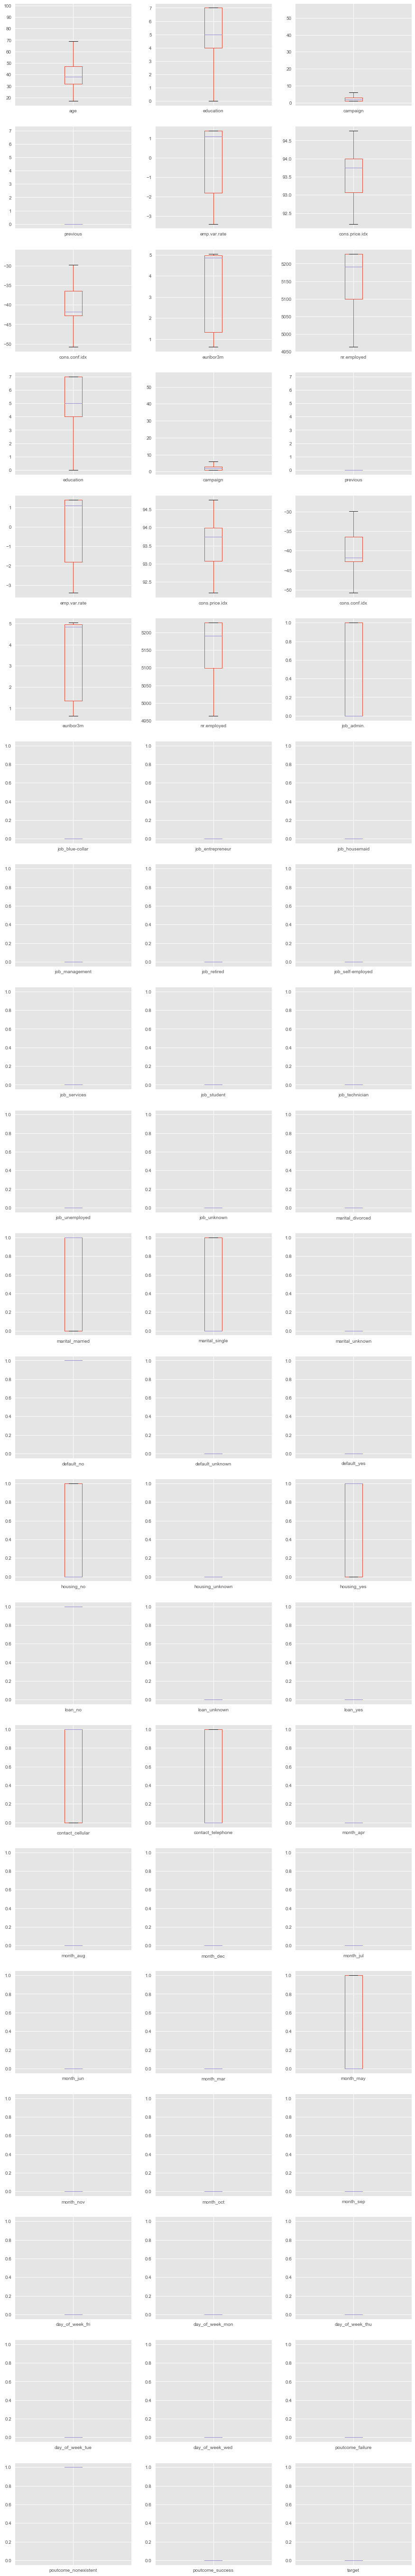

In [12]:
df_final.plot(kind='box', subplots=True, layout=(63,3), sharex=False, sharey=False, figsize=(15,300))
plt.show()

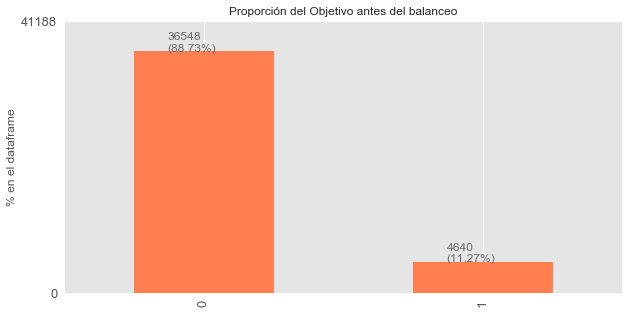

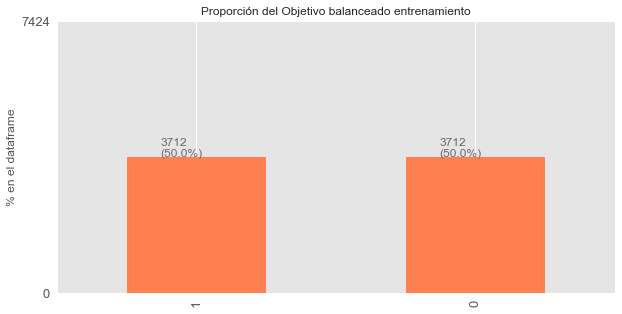

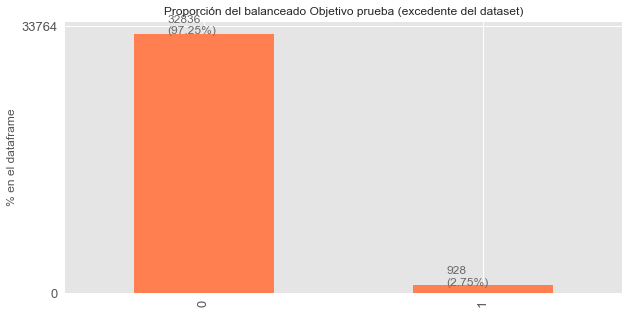

In [13]:
finalDf_train, finalDf_test=balanceo(df_final,objetivo='target',tam_muestra=80)
# print(finalDf_test.shape, finalDf_train.shape)

grafica_ver(df_final,'target','Proporción del Objetivo antes del balanceo', '% en el dataframe')
plt.subplots(1, 1)
grafica_ver(finalDf_train,'target','Proporción del Objetivo balanceado entrenamiento', '% en el dataframe')
plt.subplots(1, 1)
grafica_ver(finalDf_test,'target','Proporción del balanceado Objetivo prueba (excedente del dataset)'
            , '% en el dataframe')

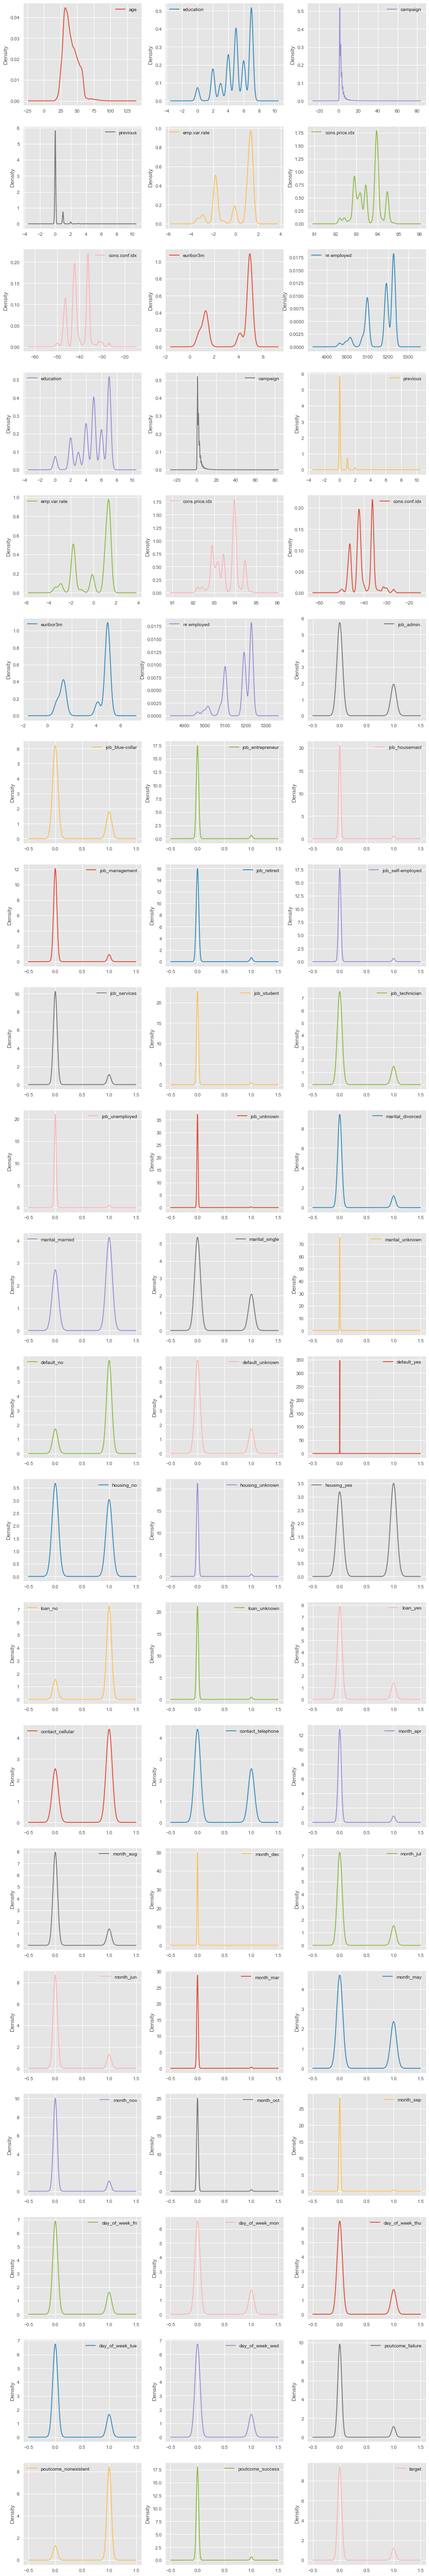

In [14]:
df_final.plot(kind='density', subplots=True, layout=(64,3), sharex=False, figsize=(15,300))
plt.show()

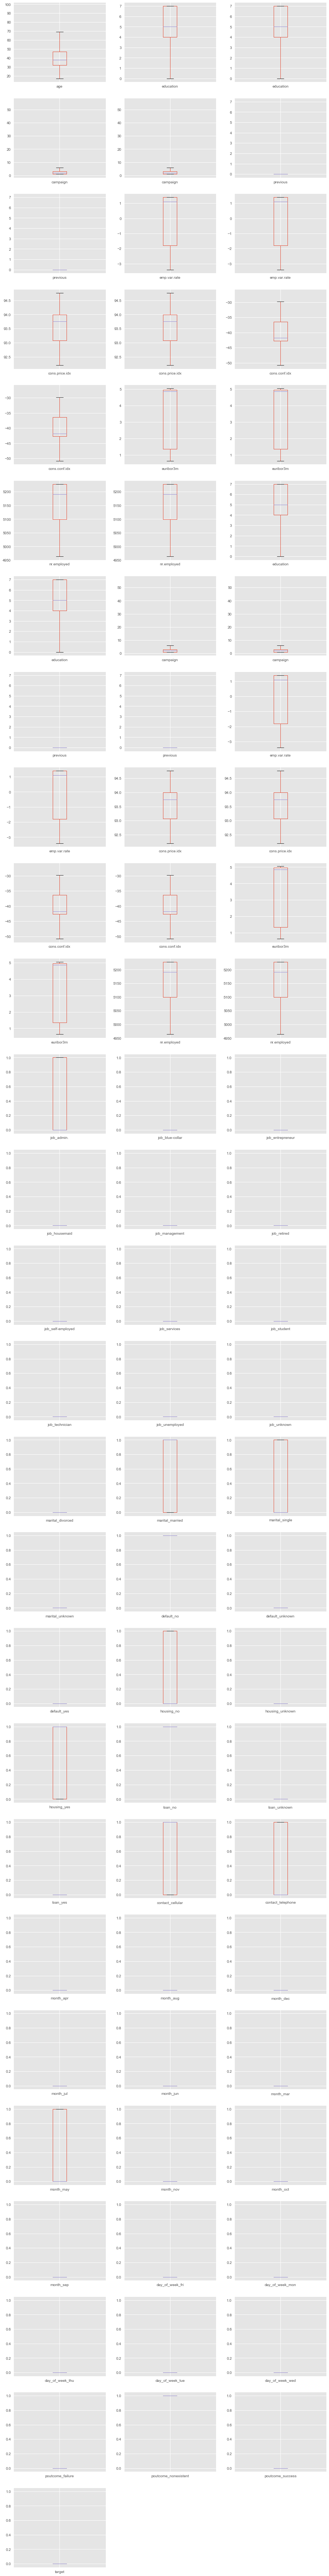

In [15]:
df_final[labels_dummy].plot(kind='box', subplots=True, layout=(64,3), sharex=False, sharey=False, figsize=(15,300))
plt.show()

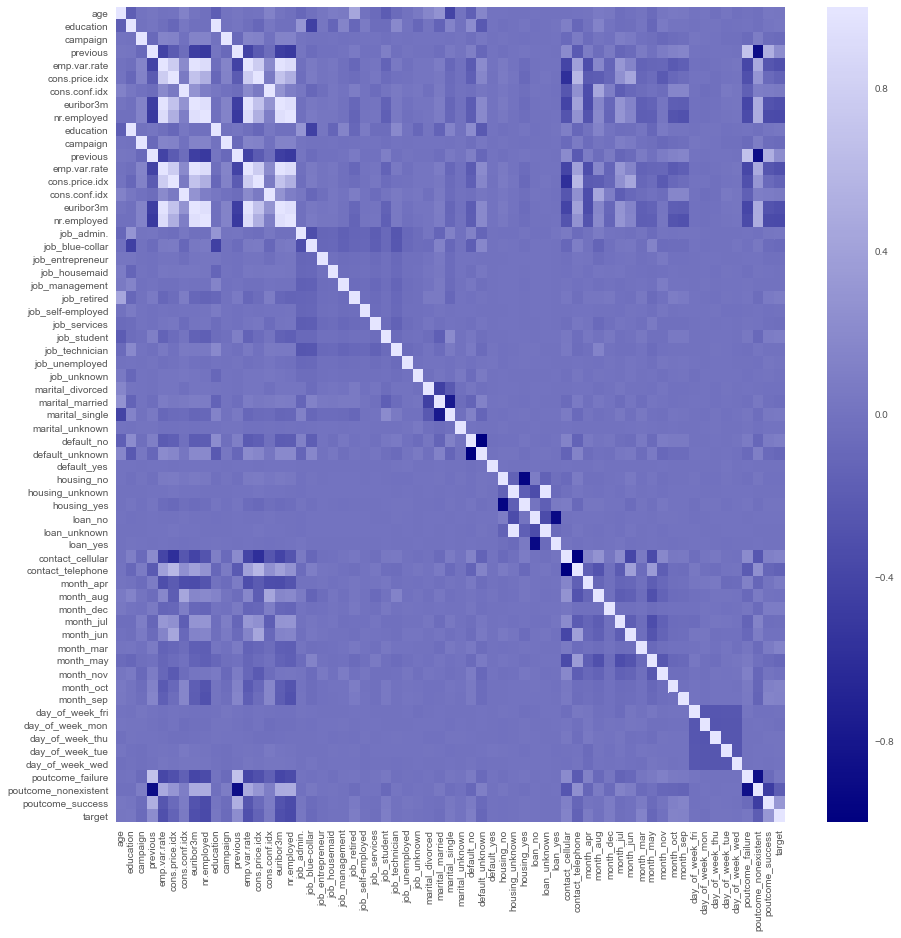

In [16]:
correlations=df_final.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(15, 15))
cmap=sns.light_palette("navy", reverse=True, as_cmap=True)
sns.heatmap(correlations, fmt="d",ax=ax, cmap=cmap)

### Linear model

Score: 0.7441077441077442
accuracy_score: 0.7441077441077442
Tasa de error: 0.25589225589225584
jaccard_similarity_score 0.7441077441077442


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.72      0.82      0.77       772
          1       0.78      0.66      0.71       713

avg / total       0.75      0.74      0.74      1485

None




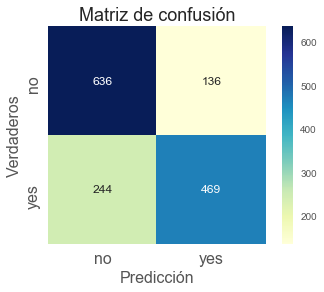

In [17]:
target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
lr = LogisticRegression(solver = 'lbfgs', max_iter=1000000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
grafica_scores(lr, x_test, y_test, y_pred)
lr_cm = confusion_matrix(y_test, y_pred)
grafica_matriz_confusion(lr_cm)

### Con los datos reales

Score: 0.8156374944469125
accuracy_score: 0.8156374944469125
Tasa de error: 0.18436250555308753
jaccard_similarity_score 0.8156374944469125


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.99      0.82      0.90     26277
          1       0.09      0.65      0.16       735

avg / total       0.96      0.82      0.88     27012

None




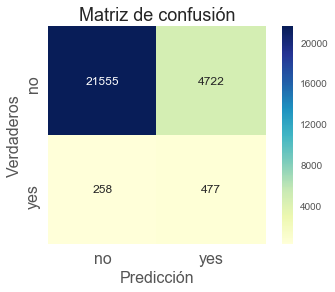

In [18]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=lr.predict(x_test_true)
grafica_scores(lr, x_test_true, y_test_true, y_test_pred_true)
lr_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(lr_cm_true)

### Knn

Score: 0.7252525252525253
accuracy_score: 0.7252525252525253
Tasa de error: 0.27474747474747474
jaccard_similarity_score 0.7252525252525253


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.69      0.81      0.74       730
          1       0.78      0.64      0.70       755

avg / total       0.73      0.73      0.72      1485

None




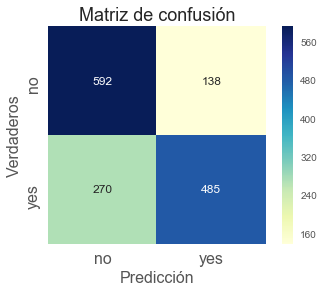

In [19]:
target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
grafica_scores(knn, x_test, y_test, y_pred)
knn_cm = confusion_matrix(y_test, y_pred)
grafica_matriz_confusion(knn_cm)

### Con los datos reales

Score: 0.8175995853694654
accuracy_score: 0.8110839626832519
Tasa de error: 0.1889160373167481
jaccard_similarity_score 0.8110839626832519


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.99      0.82      0.89     26258
          1       0.09      0.60      0.15       754

avg / total       0.96      0.81      0.87     27012

None




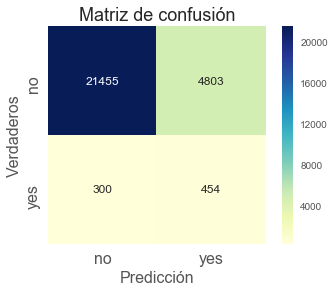

In [20]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=knn.predict(x_test_true)
grafica_scores(lr, x_test_true, y_test_true, y_test_pred_true)
knn_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(knn_cm_true)

### Decision Trees

Score: 0.7212121212121212
accuracy_score: 0.7212121212121212
Tasa de error: 0.2787878787878788
jaccard_similarity_score 0.7212121212121212


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.66      0.86      0.75       721
          1       0.82      0.59      0.68       764

avg / total       0.74      0.72      0.72      1485

None




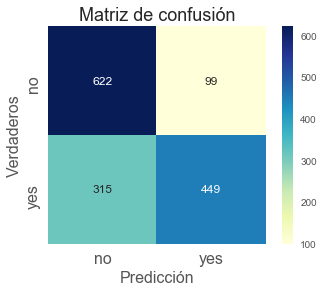

In [21]:
target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
clf_cm=confusion_matrix(y_test, y_test_pred)
grafica_scores(clf, x_test, y_test, y_test_pred)
grafica_matriz_confusion(clf_cm)

### Con los datos reales

Score: 0.8454390641196505
accuracy_score: 0.8454390641196505
Tasa de error: 0.15456093588034947
jaccard_similarity_score 0.8454390641196505


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.99      0.85      0.91     26274
          1       0.10      0.59      0.17       738

avg / total       0.96      0.85      0.89     27012

None




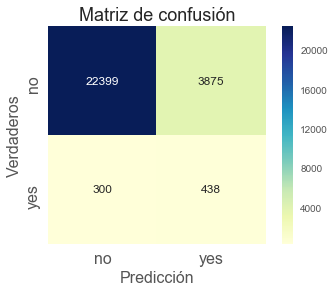

In [22]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=clf.predict(x_test_true)
grafica_scores(clf, x_test_true, y_test_true, y_test_pred_true)
clf_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(clf_cm_true)

### SVC

Score: 0.7205387205387206
accuracy_score: 0.7205387205387206
Tasa de error: 0.2794612794612794
jaccard_similarity_score 0.7205387205387206


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.67      0.83      0.74       728
          1       0.79      0.62      0.69       757

avg / total       0.73      0.72      0.72      1485

None




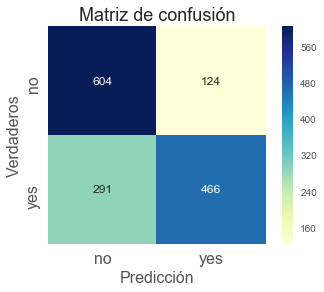

In [45]:
from sklearn.svm import SVC # "Support vector classifier"

target_train = finalDf_train.loc[:,['target']].values
x_tr = finalDf_train.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_tr,target_train, test_size=0.2)
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
y_test_pred = svm.predict(x_test)
svm_cm=confusion_matrix(y_test, y_test_pred)
grafica_scores(svm, x_test, y_test, y_test_pred)
grafica_matriz_confusion(svm_cm)

In [25]:
pd.DataFrame(svm.support_vectors_).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,52.0,7.0,2.0,0.0,1.4,93.918,-42.7,4.962,5228.1,7.0,2.0,0.0,1.4,93.918,-42.7,4.962,5228.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,46.0,2.0,1.0,0.0,1.4,93.918,-42.7,4.962,5228.1,2.0,1.0,0.0,1.4,93.918,-42.7,4.962,5228.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,40.0,6.0,2.0,0.0,1.1,93.994,-36.4,4.857,5191.0,6.0,2.0,0.0,1.1,93.994,-36.4,4.857,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,34.0,4.0,3.0,0.0,-1.8,92.893,-46.2,1.299,5099.1,4.0,3.0,0.0,-1.8,92.893,-46.2,1.299,5099.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62.0,0.0,1.0,1.0,-1.7,94.215,-40.3,0.827,4991.6,0.0,1.0,1.0,-1.7,94.215,-40.3,0.827,4991.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Con los datos reales

Score: 0.7869095216940619
accuracy_score: 0.7869095216940619
Tasa de error: 0.21309047830593808
jaccard_similarity_score 0.7869095216940619


classification_report
---------------------
              precision    recall  f1-score   support

          0       0.99      0.79      0.88     26280
          1       0.08      0.64      0.14       732

avg / total       0.96      0.79      0.86     27012

None




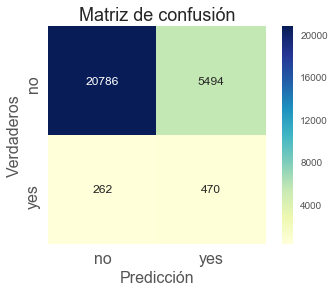

In [61]:
target_true=finalDf_test.loc[:,['target']].values
x_tr_true=finalDf_test.drop('target', axis=1)
x_train_true, x_test_true, y_train_true, y_test_true = train_test_split(x_tr_true,target_true, test_size=0.8)
y_test_pred_true=svm.predict(x_test_true)
grafica_scores(svm, x_test_true, y_test_true, y_test_pred_true)
svm_cm_true = confusion_matrix(y_test_true, y_test_pred_true)
grafica_matriz_confusion(svm_cm_true)